In [1]:
# Importing all the necessary libraries 
# And downloading word lists from the NLTK corpus

from datasets import load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from tqdm._tqdm_notebook import tqdm_notebook

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_412\4000416053.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Loading the data using Hugging Face's load_dataset encapsulation, part of the datasets library

ds_dict = load_dataset('cnn_dailymail', '3.0.0')
df = ds_dict['train'].data.to_pandas() # Converting the loaded data to a pandas DataFrame

In [3]:
# Extracting 3% of the total data for experimental purpose (approximately 9,000 articles/broadcast transcripts)
# Transforming the dataset to only include the original article and a reference summary

df = pd.DataFrame([df['article'][:(int(0.03 * df.shape[0]))], df['highlights'][:(int(0.03 * df.shape[0]))]])
df = df.T
df.head()

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [4]:
print(f"We have {df.shape[0]} data points.")

We have 8613 data points.


In [5]:
# A function to compute the approximate word count per article using whitespace as a delimiter.

def word_count(df):
    return df["article"].apply(lambda article: len(re.findall(r"\w+", str(article))))

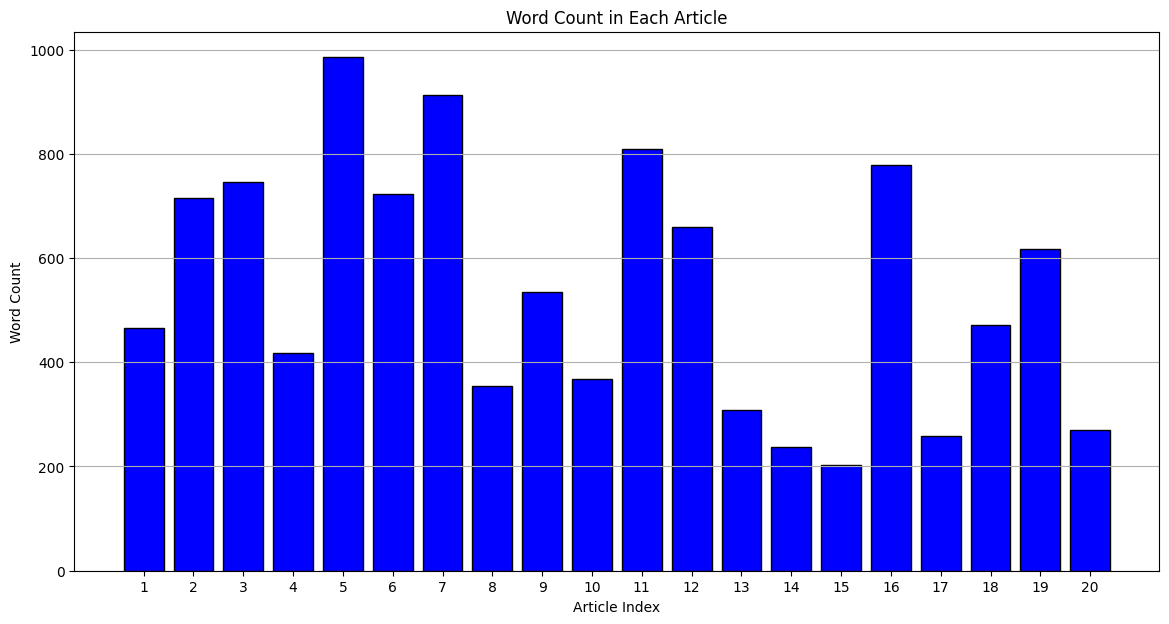

Average word count across all articles is 635.


In [6]:
# Plot the word count for each article with the x-axis translated to numbers to indicate a specific article
# Using the first 20 articles for visualization purpose

df_plot = pd.DataFrame(df["article"][:20])
plt.figure(figsize=(14, 7))
word_counts = word_count(df_plot)
plt.bar(pd.Series(df_plot.index) + 1, word_counts, color='blue', edgecolor='black')
plt.title('Word Count in Each Article')
plt.xlabel('Article Index')
plt.xticks(pd.Series(df_plot.index) + 1)  # Set x-axis ticks to show every index
plt.ylabel('Word Count')
plt.grid(axis='y')
plt.gcf().savefig("WordCount.png")
plt.show()
mean_count = word_count(df).mean()
print(f"Average word count across all articles is {int(mean_count)}.")

In [7]:
# Function for sentence tokenization. These tokenized sentences would be used eventually to build summaries for respective articles.
def sentence_tokenize(text):
    sentences = re.split(r'\.\s+', text)
    return [sentence.strip() for sentence in sentences if sentence]

df["sentences"] = df["article"].apply(sentence_tokenize) # Add the list of tokenized sentences to the data frame.

In [8]:
# Pre-processing text before vectorizing it (to get a mathematical representation)

def data_preprocess(text):
    # For text uniformity.
    text = text.lower()

    # Tokenize sentences to words.
    tokens = RegexpTokenizer(r"\w+").tokenize(text)

    # Identify stopwords to be removed
    stop_words = set(stopwords.words("english"))

    # Remove stopwords.
    words = [word for word in tokens if word not in stop_words]

    # Lemmatization.
    words = [WordNetLemmatizer().lemmatize(word) for word in words]

    # Combine to form sentences post processing.
    text = " ".join(words)

    return text

In [9]:
# Adding a progress bar to gauge how long the pre-processing would take for the entire data frame.

tqdm_notebook.pandas()

df["tokenized"] = df["sentences"].progress_apply(lambda text: [data_preprocess(str(sentence)) for sentence in text]) 

  0%|          | 0/8613 [00:00<?, ?it/s]

In [10]:
df.head() # Post pre-processing

,article,highlights,sentences,tokenized
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,"[LONDON, England (Reuters) -- Harry Potter sta...",[london england reuters harry potter star dani...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,[Editor's note: In our Behind the Scenes serie...,[editor note behind scene series cnn correspon...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...","[MINNEAPOLIS, Minnesota (CNN) -- Drivers who w...",[minneapolis minnesota cnn driver minneapolis ...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",[WASHINGTON (CNN) -- Doctors removed five smal...,[washington cnn doctor removed five small poly...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",[(CNN) -- The National Football League has in...,[cnn national football league indefinitely sus...


In [32]:
df["tokenized"][7]

['bogota colombia cnn key rebel commander fugitive u',
 'drug trafficking indictment killed weekend air attack guerrilla encampment colombian military said monday',
 'alleged cocaine trafficker farc rebel tomas medina caracas interpol photo',
 'tomas medina caracas known popularly el negro acacio member high command fuerzas armada revolucionarias de colombia according colombian u',
 'official helped manage group extensive cocaine trafficking network',
 'cross hair u',
 'justice department since 2002',
 'charged conspiracy import cocaine united state manufacturing distributing cocaine within colombia fund farc 42 year insurgency government',
 'u',
 'official alleged medina caracas managed rebel group sale cocaine international drug trafficker turn smuggled united state',
 'also indicted united state along two farc commander november 2002 charge conspiring kidnap two u',
 'oil worker neighboring venezuela 1997 holding one nine month 1 million ransom paid',
 'official said army rapid resp

In [14]:
# Vectorization of pre-processed text

def vectorize(article):
    # Build document-term matrix using the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words=None, use_idf=True)
    X = vectorizer.fit_transform(article)
    return X

In [15]:
# LSI/LSA pipeline

def perform_lsa(dtm):
    # Choose the number of components based on the number of sentences and features
    num_components = min(100, min(dtm.shape) - 1)

    if num_components < 2:
        num_components = 3

    # Perform LSA using TruncatedSVD
    svd = TruncatedSVD(num_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X_lsa = lsa.fit_transform(dtm)

    return X_lsa

In [16]:
# Function that combines all implementation to generate indices of key sentences to be used for summarization.
def summarize(article):
    # Extract key components from the text
    X_lsa =  perform_lsa(vectorize(article)) 

    # Sorting the sentences by importance
    sorted_idx = np.argsort(np.sum(X_lsa, axis=1))

    # We get the indices of the top sentences
    summary_indices = sorted_idx[-3:]

    return summary_indices

In [17]:
# Apply the function to the entire data frame

df["summary_indices"] = df["tokenized"].apply(summarize)

C:\Users\LENOVO\anaconda3\envs\NLA-FinalProject\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\LENOVO\anaconda3\envs\NLA-FinalProject\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


In [18]:
df.head()

,article,highlights,sentences,tokenized,summary_indices
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,"[LONDON, England (Reuters) -- Harry Potter sta...",[london england reuters harry potter star dani...,"[1, 19, 2]"
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,[Editor's note: In our Behind the Scenes serie...,[editor note behind scene series cnn correspon...,"[8, 39, 21]"
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...","[MINNEAPOLIS, Minnesota (CNN) -- Drivers who w...",[minneapolis minnesota cnn driver minneapolis ...,"[22, 5, 2]"
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",[WASHINGTON (CNN) -- Doctors removed five smal...,[washington cnn doctor removed five small poly...,"[17, 5, 22]"
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",[(CNN) -- The National Football League has in...,[cnn national football league indefinitely sus...,"[36, 15, 37]"


In [19]:
# A function that utilizes indices generated in the previous step to build an extractive summary for the entire DataFrame

def summary_builder(df):
    summaries = []
    for ind in df.index:
        sentences = df["sentences"][ind]
        indices = df["summary_indices"][ind]
        summary = ""
        for index in indices:
            summary += f"{sentences[index]}. "
        summaries.append(summary)
    return summaries

In [20]:
# Adding generated summaries to the DataFrame

df["summary"] = summary_builder(df)

In [21]:
df.head()

,article,highlights,sentences,tokenized,summary_indices,summary
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,"[LONDON, England (Reuters) -- Harry Potter sta...",[london england reuters harry potter star dani...,"[1, 19, 2]","Daniel Radcliffe as Harry Potter in ""Harry Pot..."
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,[Editor's note: In our Behind the Scenes serie...,[editor note behind scene series cnn correspon...,"[8, 39, 21]",He is well known in Miami as an advocate for j...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...","[MINNEAPOLIS, Minnesota (CNN) -- Drivers who w...",[minneapolis minnesota cnn driver minneapolis ...,"[22, 5, 2]","I saw a couple cars fall,"" he said. ""I realize..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",[WASHINGTON (CNN) -- Doctors removed five smal...,[washington cnn doctor removed five small poly...,"[17, 5, 22]",The president's doctor had recommended a repea...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",[(CNN) -- The National Football League has in...,[cnn national football league indefinitely sus...,"[36, 15, 37]","Judge Henry E. ""The defendant will plead guilt..."


In [28]:
# Sample Examples

original_article = df["article"][7]
print(f"Article: {original_article}") # Article
print("\n")
example_summary = df["summary"][7]
print(f"Summary: {example_summary}") # Example summary

Article: BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was al

In [23]:
from rouge import Rouge

In [30]:
rouge = Rouge() # Create a ROUGE evaluator instance

reference_summary = df["highlights"][7]

# Generate scores on the basis of the generated summary and a reference summary
output = rouge.get_scores(example_summary, reference_summary) 
print(output)

[{'rouge-1': {'r': 0.3333333333333333, 'p': 0.1935483870967742, 'f': 0.24489795453561022}, 'rouge-2': {'r': 0.075, 'p': 0.043478260869565216, 'f': 0.05504586691355986}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.1935483870967742, 'f': 0.24489795453561022}}]


In [27]:
from summarizer import Summarizer

# Initialize the BERTSUM summarizer
model = Summarizer()

# Example text to summarize
text = """
BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was also indicted in the United States along with two other FARC commanders in November 2002 on charges of conspiring to kidnap two U.S. oil workers from neighboring Venezuela in 1997 and holding one of them for nine months until a $1 million ransom was paid. Officials said the army's Rapid Response Force, backed by elements of the Colombian Air Force, tracked Medina Caracas down at a FARC camp in the jungle in the south of the country. "After a bombardment, the troops occupied the camp, and they've found 14 dead rebels so far, along with rifles, pistols, communications equipment and ... four GPS systems," Defense Minister Juan Manuel Santos said at a news conference. "The death of 'El Negro Acacio' was confirmed by various sources, including members of FARC itself." Medina Caracas commanded FARC's 16th Front in the southern departments of Vichada and Guainia. Established in 1964 as the military wing of the Colombian Communist Party, FARC is Colombia's oldest, largest, most capable and best-equipped Marxist rebel group, according to the U.S. Department of State. E-mail to a friend . Journalist Fernando Ramos contributed to this report.
"""

# Generate the summary
summary = model(text)

print("Article: ",text)

# Output the summarized text
print("Summary: ",summary)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

C:\Users\LENOVO\anaconda3\envs\NLA-FinalProject\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

C:\Users\LENOVO\anaconda3\envs\NLA-FinalProject\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Article:  
BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was 

In [29]:
# Generate scores on the basis of the generated summary and a reference summary
output = rouge.get_scores(summary, reference_summary) 
print(output)

[{'rouge-1': {'r': 0.5555555555555556, 'p': 0.3333333333333333, 'f': 0.4166666619791667}, 'rouge-2': {'r': 0.35, 'p': 0.18666666666666668, 'f': 0.24347825633270326}, 'rouge-l': {'r': 0.5555555555555556, 'p': 0.3333333333333333, 'f': 0.4166666619791667}}]
